In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : f-yGT6WO 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 540251.66
  Predicted background counts     : 533641.14
  Predicted excess counts         : 6610.53

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 100300 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2462761.56

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

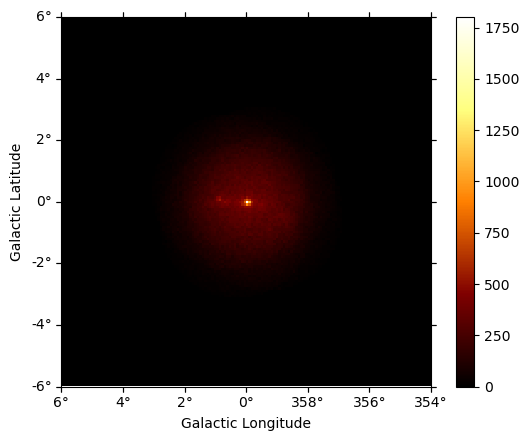

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models.remove('1745')
models.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].frozen = True
dataset_standard.models[0].parameters['lat_0'].frozen = True
dataset_standard.models[1].parameters['lon_0'].frozen = True
dataset_standard.models[1].parameters['lat_0'].frozen = True
#dataset_standard.models[2].parameters['lon_0'].frozen = True
#dataset_standard.models[2].parameters['lat_0'].frozen = True
#dataset_standard.models[3].parameters['lon_0'].frozen = True
#dataset_standard.models[3].parameters['lat_0'].frozen = True
#dataset_standard.models[4].parameters['lon_0'].frozen = True
#dataset_standard.models[4].parameters['lat_0'].frozen = True

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
#print(dataset_asimov)

In [4]:
estimator = TSMapEstimator(
    dataset_standard.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#dataset_standard.counts.geom.axes['energy'].edges[7:17]#energy_edges=[10, 500] * u.GeV#
)
maps = estimator.run(dataset_standard)

Text(0.5, 1.0, 'Iteration map')

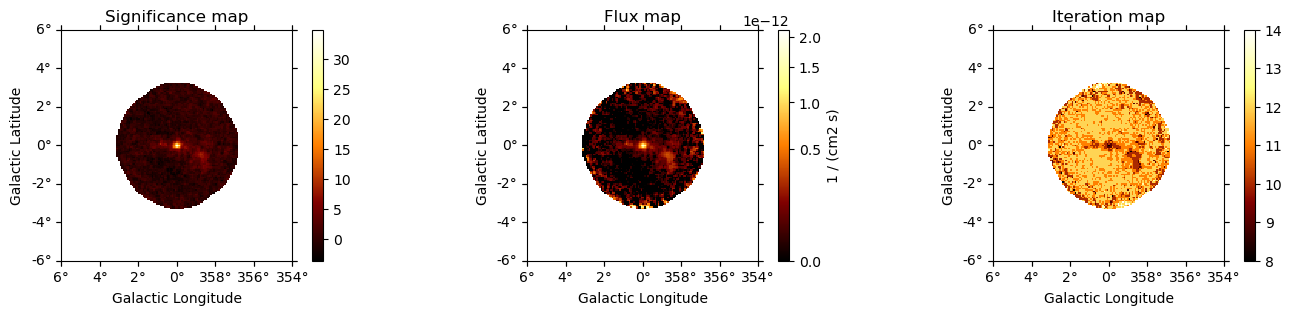

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax = ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
34.852,75,74,266.42019,-28.99116
8.8147,90,68,266.17092,-30.26529
8.5994,64,75,266.86284,-28.19759
6.8415,68,74,266.75217,-28.51273


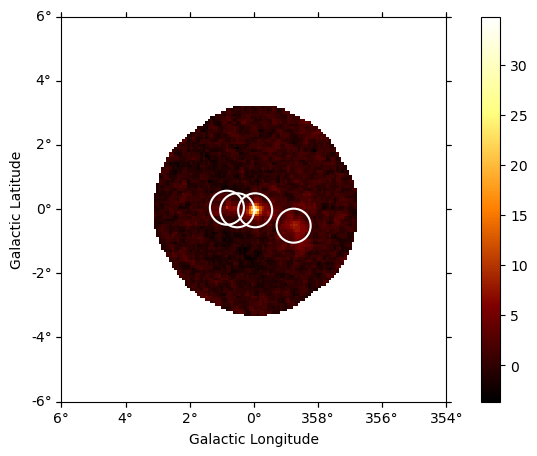

In [6]:
from gammapy.estimators.utils import find_peaks
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.25 deg")#threshold=5
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


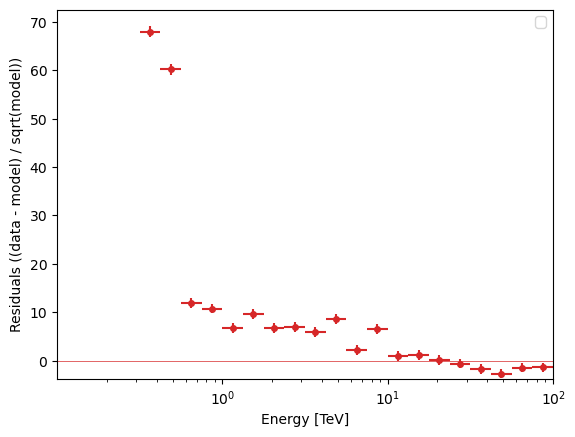

In [7]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

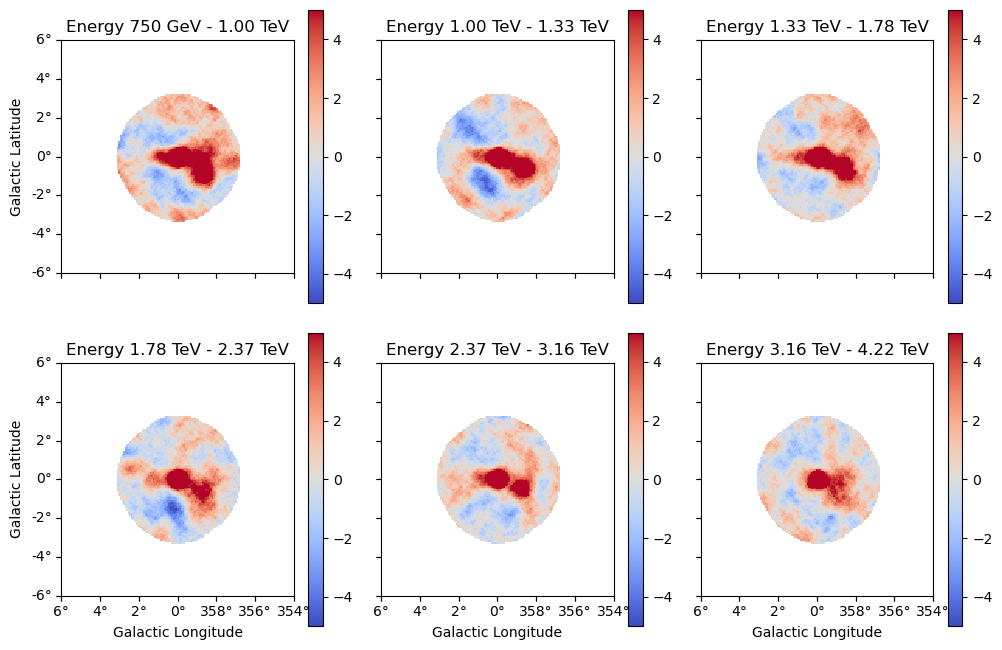

In [8]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[7:14])
result = estimator.run(dataset_standard)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

#### Setting up mask & fitting

In [9]:
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
#dataset_standard.mask_fit.plot_grid(vmin=0, vmax=1, add_cbar=True)

In [10]:
%%time
fit_standard = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_standard.backend = "minuit"
fit_standard.optimize_opts = minuit_opts
result_standard = fit_standard.run([dataset_standard])

CPU times: total: 32.3 s
Wall time: 32.3 s


In [11]:
print(dataset_standard)

MapDataset
----------

  Name                            : f-yGT6WO 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591513.99
  Predicted background counts     : 574674.29
  Predicted excess counts         : 16839.70

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303779.30

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramet

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


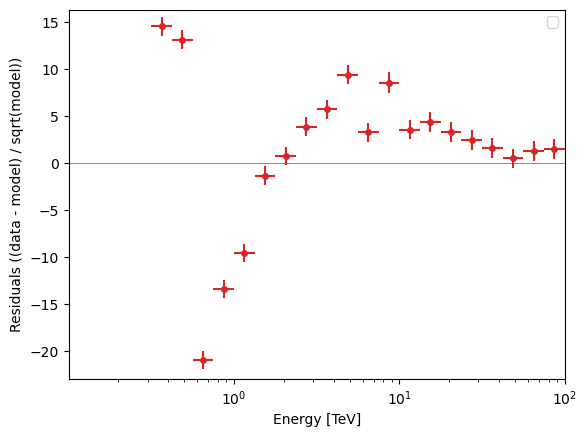

In [12]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

In [13]:
print(dataset_standard.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.051   +/-    0.04             
    amplitude                     :   2.77e-12   +/- 8.2e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    359.940       deg         
    lat_0                 (frozen):     -0.050       deg         




In [14]:
estimator = TSMapEstimator(
    dataset_standard.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#energy_edges=dataset_standard.counts.geom.axes['energy'].edges[10:14]
)
maps = estimator.run(dataset_standard)

Text(0.5, 1.0, 'Iteration map')

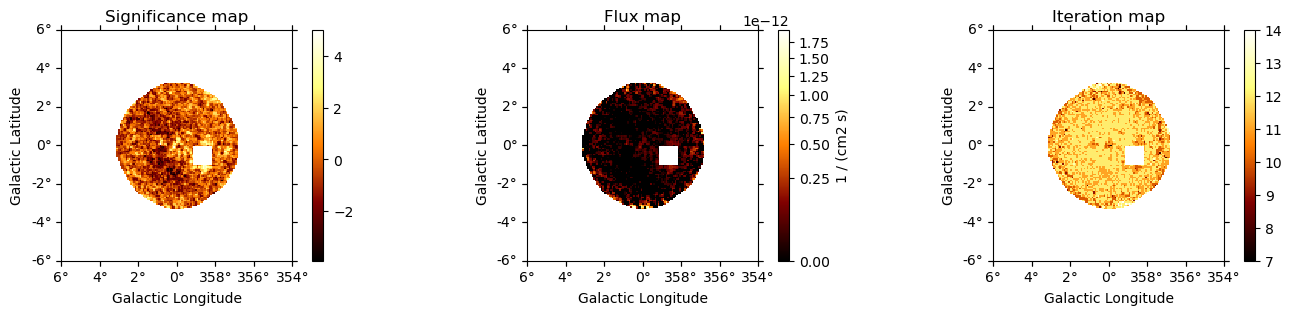

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
5.0259,73,73,266.59339,-28.89615


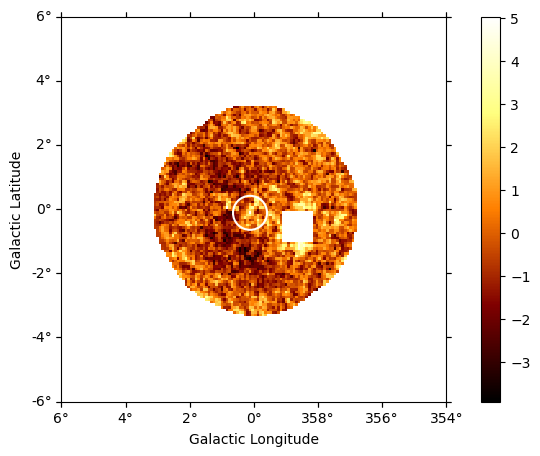

In [16]:
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.25 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

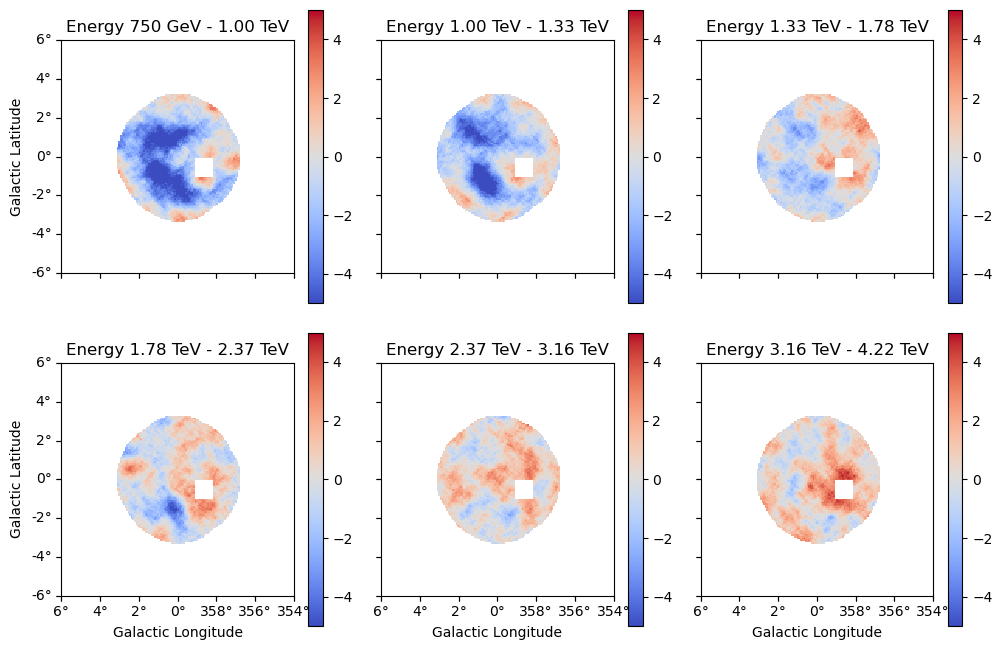

In [17]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[7:14])
result = estimator.run(dataset_standard)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [18]:
model2 = Models(dataset_standard.models).copy()
model2.remove('diff')

In [19]:
print(model2)

Models

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.051   +/-    0.04             
    amplitude                     :   2.77e-12   +/- 8.2e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    359.940       deg         
    lat_0                 (frozen):     -0.050       deg         

Component 1: SkyModel

  Name                      : g09
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index       

In [20]:
model2.write("data/1_model_standard_best_fit_mask.yml", overwrite= True)